In [1]:
import tqdm
import scipy.stats

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Reading FL file and found features
fl_file = "results/process_feature_output_formatting_openms/output_start_parameter_worked_9_FL_param_QT_3/linked_features_quantification.tsv"
fl_df = pd.read_csv(fl_file,sep="\t").round(5)
found_feature_file = "found_features.csv"
IS_df = pd.read_csv(found_feature_file).round(5)
mz_fl = IS_df["mz_fl"].to_list()
rt_fl = IS_df["rt_fl"].to_list()
cmpd_name = IS_df["cmpd_name"].to_list()
cmpd_type = IS_df["cmpd_type"].to_list()

In [3]:
# Selecting intensities of all the found features from FeatureLinker file
output_intensities = []
index = 0
df_dict = {}
for i in tqdm.tqdm(range(len(mz_fl))):
    rt = rt_fl[i]
    mz = mz_fl[i]
    cmd_typ = cmpd_type[i]
    cmd_nme = cmpd_name[i]
    if cmd_typ.lower() == "native":
        intensity_list = []
        sub_df = fl_df[(fl_df["mz_cf"] == mz) & (fl_df["rt_cf"] == rt)]
        for key in sub_df.to_dict('records')[0]:
            if "Met_ID" in key:
                met_id = sub_df.to_dict('records')[0][key]
            if "intensity_Sample" in key:
                intensity = sub_df.to_dict('records')[0][key]
                try:
                    intensity = float(intensity)
                    if str(intensity) != "nan":
                        intensity_list.append(intensity)
                    else:
                        intensity_list.append("None")
                except:
                    pass
        coverage = np.sum(np.array(intensity_list,dtype=np.str) != "None")
        output_intensities.append({"index":index,"id":met_id,"intensity":intensity_list,"cmpd_name":cmd_nme,"coverage":coverage})
        df_dict["metID_" + str(met_id)] = intensity_list
        index += 1

  0%|                                                                      | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_151395/2577385015.py:26: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coverage = np.sum(np.array(intensity_list,dtype=np.str) != "None")
100%|█████████████████████████████████████████████████████████████| 38/38 [00:22<00:00,  1.68it/s]


In [4]:
# Creating a dataframe with a coverage cutoff
coverage_cutoff = 15
colname_intensity = {}
for entry in output_intensities:
    intensity = entry["intensity"]
    colname = entry['cmpd_name'] + " (" + str(entry["coverage"]) + "%)"
    if entry["coverage"] >= coverage_cutoff:
        colname_intensity[colname] = intensity
        
df_with_cutoff = pd.DataFrame.from_dict(colname_intensity)

In [5]:
from scipy.stats import pearsonr

# Creating correlation matrix and the p-values
corr_matrix = np.zeros((df_with_cutoff.shape[1],df_with_cutoff.shape[1]))
pval_matrix = np.zeros((df_with_cutoff.shape[1],df_with_cutoff.shape[1]))
pval_matrix_symbol = np.zeros((df_with_cutoff.shape[1],df_with_cutoff.shape[1])).astype('str')

def get_person_corr(arr1,arr2):
    condition = (arr1 != "None") & (arr2 != "None")
    if np.sum(condition) > 2:
        a1 = arr1[condition].astype('float64')
        b1 = arr2[condition].astype('float64')
        return (pearsonr(a1, b1))
    else:
        return (0,1)
    
for i,column1 in enumerate(df_with_cutoff):
    for j,column2 in enumerate(df_with_cutoff):
        np_arr1 = np.array(df_with_cutoff[column1].to_list()).astype('str')
        np_arr2 = np.array(df_with_cutoff[column2].to_list()).astype('str')
        corr,pval = get_person_corr(np_arr1,np_arr2)
        
        pval_rep = "\n "
        for value in [0.001,0.01,0.05]:
            if pval <= value:
                pval_rep += "*"
                
        pval_matrix_symbol[i,j] = pval_rep
        pval_matrix_symbol[j,i] = pval_rep
        corr_matrix[i,j] = corr
        corr_matrix[j,i] = corr
        
        pval_matrix[i,j] = pval
        pval_matrix[j,i] = pval

corr_matrix_with_pval = np.char.add(corr_matrix.round(2).astype("str"), pval_matrix_symbol.astype("str"))

In [6]:
# Creating a correlation df
column_label = df_with_cutoff.columns.to_list()
df = pd.DataFrame.from_records(corr_matrix,columns=column_label)
df.set_axis(column_label, axis=0,inplace=True)

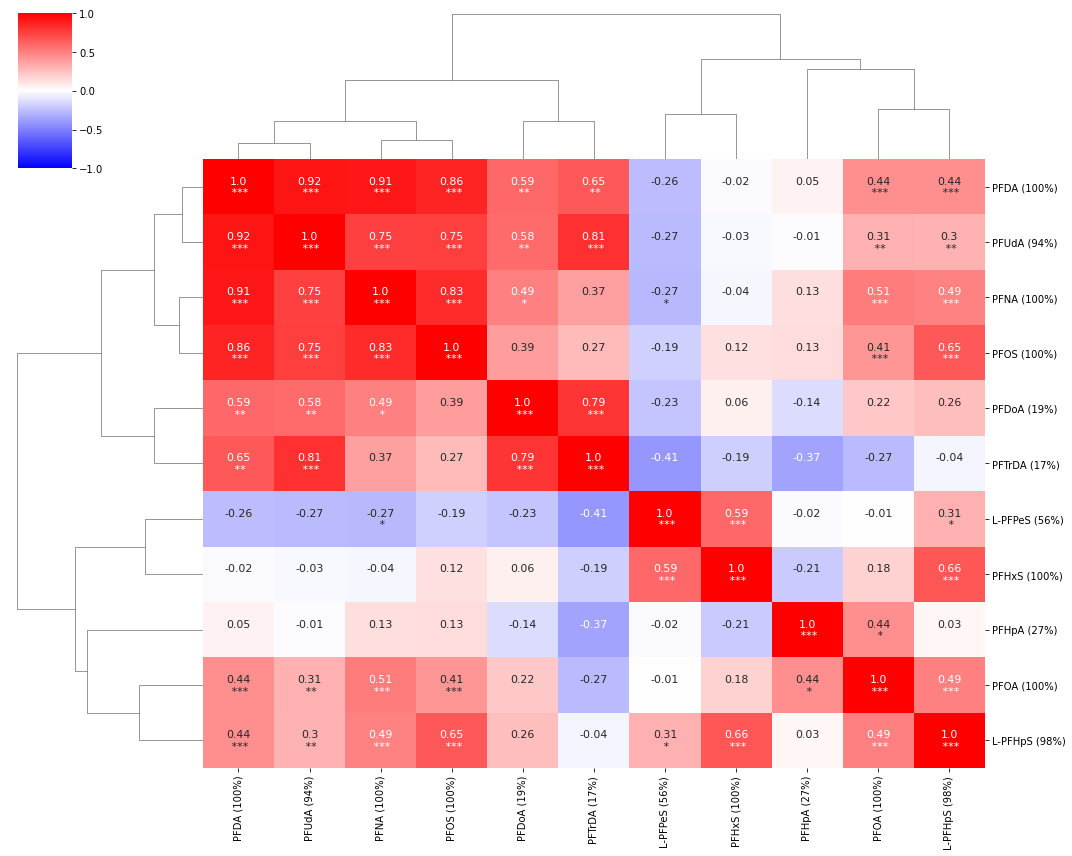

In [7]:
# Correlation plot
import matplotlib.pyplot as plt
cluster_map = sns.clustermap(df, method="complete", cmap='bwr', 
               annot_kws={"size": 11}, vmin=-1, vmax=1, figsize=(15,12),annot=corr_matrix_with_pval,fmt="");

In [8]:
cluster_map.figure.savefig("analysis_results/corr_plot.pdf",dpi=600)